# Algorithmic Trading Project: Equal-Weight S&P 500 Screener

- Similar to other existing Equal-Weight S&P 500 Funds i.e. the Invesco S&P 500® Equal Weight ETF (Fund), which is based on the S&P 500 Equal Weight Index (Index) and will invest at least 90% of its total assets in securities that comprise the Index (Invesco).
- According to Forbes Advisor, "as the top benchmark for U.S. stock market performance, the S&P 500 has spawned numerous exchange-traded funds (ETFs) designed to duplicate its performance. Funds that track this key index provide the cornerstone for the portfolios of countless buy-and-hold investors." According to the platform, the Best S&P 500 ETFs as of February 2022 are SPDR S&P 500 ETF (SPY), iShares Core S&P 500 ETF (IVV), and Vanguard S&P 500 ETF (VOO) based on their expense ratio, one-year return, and dividend yield.
- This project will produce a notebook that accepts the values of the portfolio and suggests how many shares of each component in the S&P 500 should be purchased to get an equal-weight version of the index fund.

## Library Imports

**Library imports** of open-source software libraries for the project.

In [1]:
import numpy as np
import pandas as pd
import requests
import xlsxwriter
import math

## S&P 500 Constituents

**Import the constituents** of the S&P 500. The S&P 500 constituents change over time. Although it is best to connect directly to the index provider (S&P - Standard and Poor) to regularly update the constituents, since access to the index provider is costly, I will use a static version of the S&P 500 constituents.

The static version of the S&P 500 constituents that I use for this project was last updated on November 2021, so as of the time of this project (mid-February 2022), this dataset is reasonably up-to-date.

Below is the list of companies in the S&P 500 from the static file taken from [DataHub.io](https://datahub.io/core/s-and-p-500-companies).

In [2]:
stocks = pd.read_csv('sp500_constituents.csv')
stocks

,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care
...,...,...,...
500,YUM,Yum! Brands,Consumer Discretionary
501,ZBRA,Zebra Technologies,Information Technology
502,ZBH,Zimmer Biomet,Health Care
503,ZION,Zions Bancorp,Financials


According to Forbes Advisor, the S&P 500 has more than 500 stocks (505) because Alphabet and other companies have more than one class of shares with a substantial market cap. As a result, the S&P 500 may contain more than 500 stocks, even though it only includes 500 companies.

## Change in Ticker Symbol as of February 2022

In [3]:
stocks.loc[stocks['Symbol'] == 'WLTW']

,Symbol,Name,Sector
495,WLTW,Willis Towers Watson,Financials


According to [MarketWatch](https://www.marketwatch.com/story/willis-towers-watson-changing-ticker-symbol-to-wtw-2022-01-07) on January 7th 2022, Willis Towers Watson said that they have changed their ticker symbol to 'WTW'. Hence, we will make appropriate adjustment to our stock ticket list that is 3 months behind.

In [4]:
stocks = stocks.replace('WLTW', 'WTW')
stocks.loc[stocks['Symbol'] == 'WTW']

,Symbol,Name,Sector
495,WTW,Willis Towers Watson,Financials


In addition to WTW, effective February 16th 2022, ViacomCBS will rebrand to Paramount Global. The corresponding ticker for VIAC stock will change to PARA for Class B common stock. For Class A common stock, the ticker will change to PARAA.

In [5]:
stocks.loc[stocks['Symbol'] == 'VIAC']

,Symbol,Name,Sector
473,VIAC,ViacomCBS,Communication Services


In [6]:
stocks = stocks.replace('VIAC', 'PARA')
stocks.loc[stocks['Symbol'] == 'PARA']

,Symbol,Name,Sector
473,PARA,ViacomCBS,Communication Services


## Acquire an API token

I will import IEX Cloud API token - the data provider that I will be using in my three algo-trading projects (the other two being Quantitaive Momentum Screener and Quantitative Value Screener).

In addition, we will use sandbox API token in the three projects, meaning that the data I use are randomly generated and **free**!

In [7]:
from secrets import IEX_CLOUD_API_TOKEN

## API call

API call for market capitalization and price of each stock to build our equal-weight strategy S&P 500 strategy.

In [8]:
symbol = 'FB'
api_url = f'https://sandbox.iexapis.com/stable/stock/{symbol}/quote/?token={IEX_CLOUD_API_TOKEN}'
data = requests.get(api_url).json()
print(data)

{'avgTotalVolume': 53158278, 'calculationPrice': 'close', 'change': -1.62, 'changePercent': -0.00759, 'close': 209.81, 'closeSource': 'cfalifio', 'closeTime': 1703721970163, 'companyName': 'Meta Platforms Inc - Class A', 'currency': 'USD', 'delayedPrice': 215.683, 'delayedPriceTime': 1676078757365, 'extendedChange': -1.63, 'extendedChangePercent': -0.00757, 'extendedPrice': 211, 'extendedPriceTime': 1671864833201, 'high': 219.32, 'highSource': 'ueml1y ecpeidd5aetnr  i', 'highTime': 1661761597561, 'iexAskPrice': None, 'iexAskSize': None, 'iexBidPrice': None, 'iexBidSize': None, 'iexClose': 210.69, 'iexCloseTime': 1714677474560, 'iexLastUpdated': None, 'iexMarketPercent': None, 'iexOpen': 212.843, 'iexOpenTime': 1703252504452, 'iexRealtimePrice': None, 'iexRealtimeSize': None, 'iexVolume': None, 'lastTradeTime': 1710581983250, 'latestPrice': 207.04, 'latestSource': 'Close', 'latestTime': 'February 18, 2022', 'latestUpdate': 1696406688496, 'latestVolume': 38891928, 'low': 209.81, 'lowSour

## Parse data

Parse data (from API call) for proper format.

In [9]:
market_cap = data['marketCap']
price = data['latestPrice']
print(price)

207.04


Latest price is super close to today (Feb 19, 2022)'s actual price of Meta stock, $206.16. 

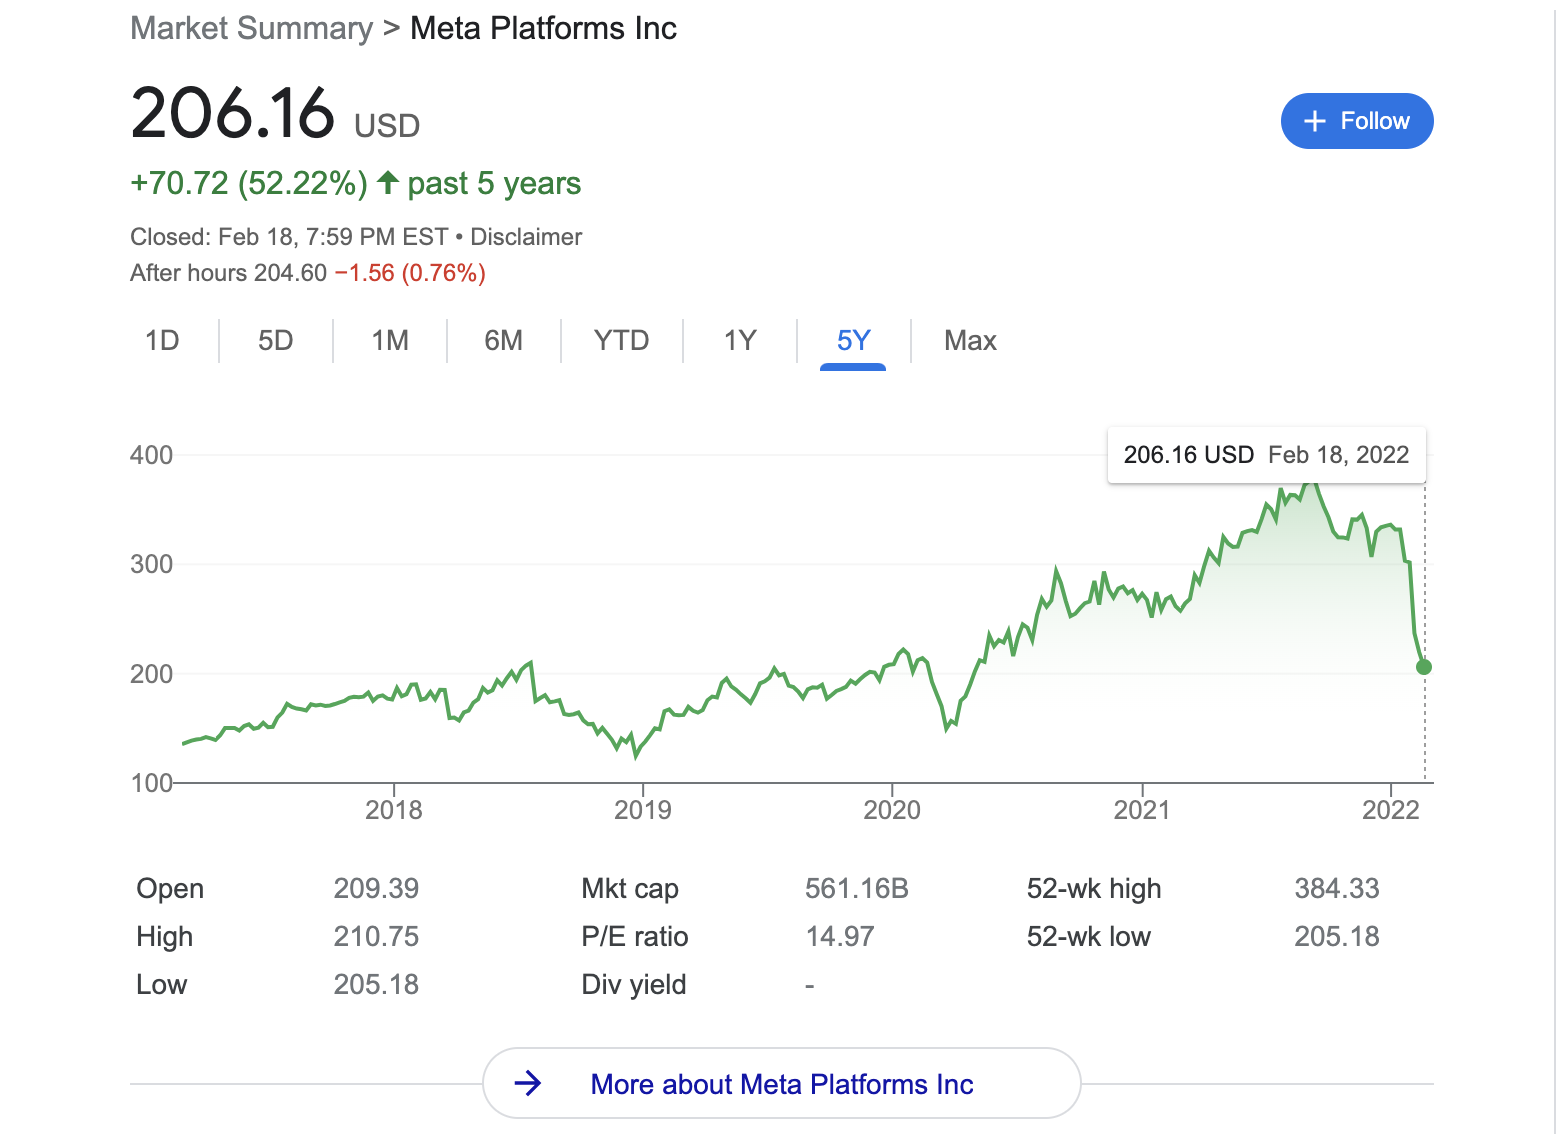

## DataFrame

Add data to a Pandas **DataFrame**.

In [10]:
df_columns = ['Ticker', 'Stock Price', 'Market Capitalization', 'Number of Shares to Buy']
df = pd.DataFrame(columns = df_columns)
df

,Ticker,Stock Price,Market Capitalization,Number of Shares to Buy


In [11]:
symbol = 'MMM'

df.append(
    pd.Series(
        [
            symbol,
            price,
            market_cap,
            'N/A'
        ],
        index = df_columns
    ),
    ignore_index = True
)

,Ticker,Stock Price,Market Capitalization,Number of Shares to Buy
0,MMM,207.04,615299169118,N/A


## Loop

**Loop** through tickers in our stock list.

In [12]:
final_df = pd.DataFrame(columns = df_columns)
for stock in stocks['Symbol']:
    api_url = f'https://sandbox.iexapis.com/stable/stock/{stock}/quote/?token={IEX_CLOUD_API_TOKEN}'
    response = requests.get(api_url)
    response.raise_for_status() # raises exception when not a 2xx response
    if response.status_code != 204:
        data = response.json()
        final_df = final_df.append(
            pd.Series(
                [
                    stock,
                    data['latestPrice'],
                    data['marketCap'],
                    'N/A'
                ],
                index = df_columns
            ),
            ignore_index = True
        )

In [13]:
final_df

,Ticker,Stock Price,Market Capitalization,Number of Shares to Buy
0,MMM,147.74,85369787176,N/A
1,AOS,72.80,12032709971,N/A
2,ABT,117.89,208051386432,N/A
3,ABBV,149.32,261867724463,N/A
4,ABMD,301.02,13846224286,N/A
...,...,...,...,...
500,YUM,126.00,38217424860,N/A
501,ZBRA,435.92,22458389352,N/A
502,ZBH,126.77,25905403478,N/A
503,ZION,73.35,11164931942,N/A


## Batch API Calls

**Batch API calls** to improve performance (as HTTP requests are often the slower components of the script.

IEX Cloud limits their batch API calls to 100 tickers per request, so we will split the list of stocks into groups of 100 to make a batch API call for each group.

In [14]:
def chunks(lst, n):
    '''Yield successive n-sized chunks from lst.'''
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [15]:
symbol_groups = list(chunks(stocks['Symbol'], 100))
symbol_groups

[0      MMM
 1      AOS
 2      ABT
 3     ABBV
 4     ABMD
       ... 
 95      CE
 96     CNC
 97     CNP
 98    CDAY
 99    CERN
 Name: Symbol, Length: 100, dtype: object,
 100      CF
 101     CRL
 102    SCHW
 103    CHTR
 104     CVX
        ... 
 195     FRC
 196      FE
 197    FISV
 198     FLT
 199     FMC
 Name: Symbol, Length: 100, dtype: object,
 200       F
 201    FTNT
 202     FTV
 203    FBHS
 204    FOXA
        ... 
 295     MRO
 296     MPC
 297    MKTX
 298     MAR
 299     MMC
 Name: Symbol, Length: 100, dtype: object,
 300     MLM
 301     MAS
 302      MA
 303    MTCH
 304     MKC
        ... 
 395      RF
 396     RSG
 397     RMD
 398     RHI
 399     ROK
 Name: Symbol, Length: 100, dtype: object,
 400     ROL
 401     ROP
 402    ROST
 403     RCL
 404    SPGI
        ... 
 495     WTW
 496    WYNN
 497     XEL
 498    XLNX
 499     XYL
 Name: Symbol, Length: 100, dtype: object,
 500     YUM
 501    ZBRA
 502     ZBH
 503    ZION
 504     ZTS
 Name: Symbol, d

In [16]:
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))

final_df = pd.DataFrame(columns = df_columns)

for symbol_string in symbol_strings:
    batch_api_call_url = f'https://sandbox.iexapis.com/stable/stock/market/batch?symbols={symbol_string}&types=quote&token={IEX_CLOUD_API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    for symbol in symbol_string.split(','):
        final_df = final_df.append(
            pd.Series(
                [
                symbol,
                data[symbol]['quote']['latestPrice'],
                data[symbol]['quote']['marketCap'],
                'N/A'   
                ],
                index = df.columns
            ),
            ignore_index = True
        )

final_df


,Ticker,Stock Price,Market Capitalization,Number of Shares to Buy
0,MMM,150.48,87675513391,N/A
1,AOS,74.70,11999280734,N/A
2,ABT,118.90,215600921784,N/A
3,ABBV,149.13,255441314010,N/A
4,ABMD,306.75,13892533232,N/A
...,...,...,...,...
500,YUM,127.10,37701788275,N/A
501,ZBRA,431.59,23155724667,N/A
502,ZBH,122.78,25380317841,N/A
503,ZION,74.12,11459579797,N/A


## Calculate the Number of Shares to Buy

In [17]:
portfolio_size = input('Please enter the value of your portfolio: ')

try:
    val = float(portfolio_size)
    print(val)
except ValueError:
    print('Please enter a number.')
    portfolio_size = input('Please once again enter the value of your portfolio: ')

Please enter the value of your portfolio: 100000
100000.0


In [18]:
position_size = val / len(final_df.index)
for i in range(0, len(final_df.index)):
    final_df.loc[i, 'Number of Shares to Buy'] = math.floor(position_size / final_df.loc[i, 'Stock Price'])

final_df

,Ticker,Stock Price,Market Capitalization,Number of Shares to Buy
0,MMM,150.48,87675513391,1
1,AOS,74.70,11999280734,2
2,ABT,118.90,215600921784,1
3,ABBV,149.13,255441314010,1
4,ABMD,306.75,13892533232,0
...,...,...,...,...
500,YUM,127.10,37701788275,1
501,ZBRA,431.59,23155724667,0
502,ZBH,122.78,25380317841,1
503,ZION,74.12,11459579797,2


## Format Excel output 

With XlsxWriter library.

### Initialize our XlsxWrite object

In [25]:
writer = pd.ExcelWriter('recommended_trades.xlsx', engine='xlsxwriter')
final_df.to_excel(writer, 'Recommended Trades', index = False)

### Format `xlsx` file

- String format for ticker
- \$XX.XX for price
- \$XX,XXX for market capitalization
- Integer format for the number of shares to purchase

In [26]:
background_color = '#808080'
font_color = '#FFFFFF'

string_format = writer.book.add_format(
    {
        'font_color' : font_color,
        'bg_color' : background_color,
        'border' : 1
    }
)

dollar_format = writer.book.add_format(
    {
        'num_format' : '$0.00',
        'font_color' : font_color,
        'bg_color' : background_color,
        'border' : 1
    }
)

integer_format = writer.book.add_format(
    {
        'num_format' : '0',
        'font_color' : font_color,
        'bg_color' : background_color,
        'border' : 1
    }
)

### Apply formats to columns of `xlsx` file

In [27]:
writer.sheets['Recommended Trades'].set_column('A:A', 18, string_format)
writer.save()

In [28]:
column_formats = {
    'A' : ['Ticker', string_format],
    'B' : ['Stock Price', dollar_format],
    'C' : ['Market Capitalization', dollar_format],
    'D' : ['Number of Shares to Buy', integer_format]
}

for column in column_formats.keys():
    writer.sheets['Recommended Trades'].set_column(f'{column}:{column}', 18, column_formats[column][1])
    writer.sheets['Recommended Trades'].write(f'{column}1', column_formats[column][0], column_formats[column][1])
    
writer.save()